In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
import datetime as dt
import xgboost as xgb

from sklearn import ensemble
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
import joblib
pd.set_option('display.width', 200)       # Ancho total de la consola
pd.set_option('display.max_columns', None)  # Mo
import os
import kagglehub

In [2]:
path = kagglehub.dataset_download("metawave/vehicle-price-prediction")
csv_path = os.path.join(path, "vehicle_price_prediction.csv")
base= pd.read_csv(csv_path)

# Analisis Exploratorio de la información EDA

- Vemos un poco tipo de datos y cantidad de registros

In [3]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   make              1000000 non-null  object 
 1   model             1000000 non-null  object 
 2   year              1000000 non-null  int64  
 3   mileage           1000000 non-null  int64  
 4   engine_hp         1000000 non-null  int64  
 5   transmission      1000000 non-null  object 
 6   fuel_type         1000000 non-null  object 
 7   drivetrain        1000000 non-null  object 
 8   body_type         1000000 non-null  object 
 9   exterior_color    1000000 non-null  object 
 10  interior_color    1000000 non-null  object 
 11  owner_count       1000000 non-null  int64  
 12  accident_history  249867 non-null   object 
 13  seller_type       1000000 non-null  object 
 14  condition         1000000 non-null  object 
 15  trim              1000000 non-null  object 
 16  v

- La columna accident_history tiene valores nulos , por lo que se debe analizar



In [4]:
print(f'Se observa que la columna accident_history tiene dos posibles valores. \n\n{base['accident_history'].value_counts()}\n\n'
      f'Hay un total de {base['accident_history'].isna().sum()} faltantes , aquellos que no tengan  \n'
      f'informacion, se consideraran como sin_accidentes\n')



Se observa que la columna accident_history tiene dos posibles valores. 

accident_history
Minor    199981
Major     49886
Name: count, dtype: int64

Hay un total de 750133 faltantes , aquellos que no tengan  
informacion, se consideraran como sin_accidentes



In [5]:
base['accident_history']=np.where(base['accident_history'].isna(),'sin_accidente',base['accident_history'])

- Detalle por Marca de vehículo

In [52]:

## Modelos de autos relevados
resultado = base.groupby('make').agg(
    modelos=('model', 'nunique'),
    registros=('model', 'count'),
    anti_prom=('vehicle_age', lambda x: round(x.mean(), 2)),
    precio_prom=('price', lambda x : round (x.mean(),2)),
    can_incidentes_graves=('accident_history',lambda x : (x == 'Major').sum()),
    can_incidentes_leves=('accident_history',lambda x : (x == 'Minor').sum()),
    can_sin_incidentes=('accident_history',lambda x : (x == 'sin_accidente').sum()),
    popularidad_marca=('brand_popularity', 'mean'))
print(f'{resultado[['modelos','registros','anti_prom','precio_prom']].to_markdown()}\n\n')



| make          |   modelos |   registros |   anti_prom |   precio_prom |
|:--------------|----------:|------------:|------------:|--------------:|
| Acura         |         4 |       40147 |        7.61 |      21924.9  |
| Audi          |         5 |       40022 |        7.59 |      27611.1  |
| BMW           |         5 |       39840 |        7.59 |      25483.8  |
| Cadillac      |         4 |       39847 |        7.58 |      30385.5  |
| Chevrolet     |         5 |       39982 |        7.59 |      15116.1  |
| Chrysler      |         2 |       40059 |        7.6  |      17827.8  |
| Dodge         |         3 |       40035 |        7.61 |      15767.9  |
| Ford          |         5 |       39842 |        7.58 |      13809.8  |
| GMC           |         4 |       39754 |        7.6  |      19205.4  |
| Honda         |         5 |       40015 |        7.57 |      11205.4  |
| Hyundai       |         4 |       39318 |        7.59 |       9873.23 |
| Jeep          |         4 |       40

In [53]:
print('Resumen estadistico de las variables por Marca\n----------------------------------------------')
print(f'Total de registros: {len(base)}\n')
print('Media de registros\n-------------------') 
for i in resultado.columns: 
    print(f'{i:<25}:  {resultado[i].mean():>10.2f}')


Resumen estadistico de las variables por Marca
----------------------------------------------
Total de registros: 1000000

Media de registros
-------------------
modelos                  :        4.20
registros                :    40000.00
anti_prom                :        7.59
precio_prom              :    20324.66
can_incidentes_graves    :     1995.44
can_incidentes_leves     :     7999.24
can_sin_incidentes       :    30005.32
popularidad_marca        :        0.04


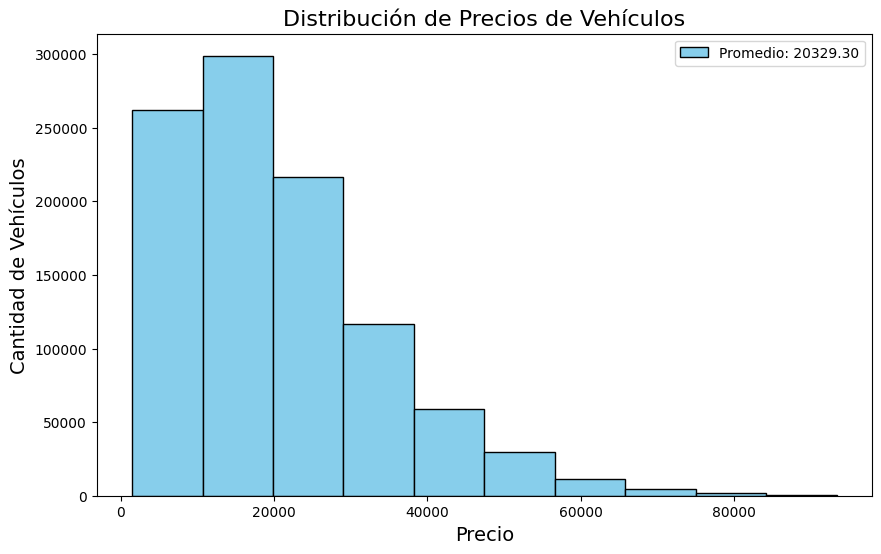

In [54]:
plt.figure(figsize=(10,6))
plt.hist(base['price'], color='skyblue', edgecolor='black')
plt.title('Distribución de Precios de Vehículos', fontsize=16)
plt.xlabel('Precio', fontsize=14)
plt.ylabel('Cantidad de Vehículos', fontsize=14)


# Línea de promedio
promedio = base['price'].mean()
plt.legend([f'Promedio: {promedio:.2f}'])



plt.show()

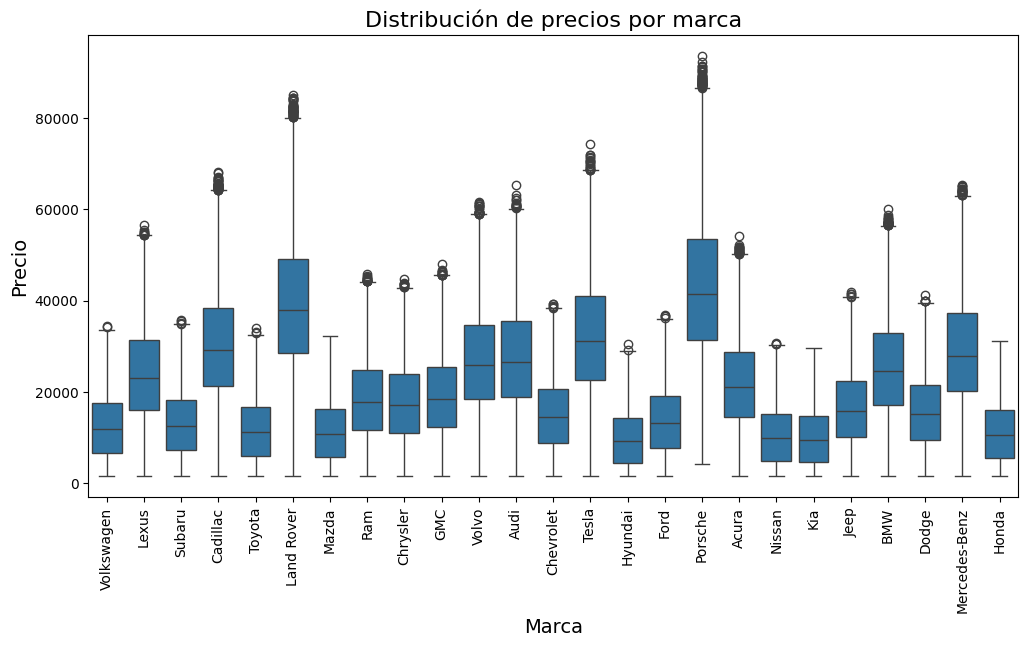

In [55]:
plt.figure(figsize=(12,6))
sns.boxplot(x="make", y="price", data=base)

plt.title("Distribución de precios por marca", fontsize=16)
plt.xlabel("Marca", fontsize=14)
plt.ylabel("Precio", fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [60]:
print(f'\n\nestadisticas Generales del conjunto de datos\n-------------------\n')

base.describe()



estadisticas Generales del conjunto de datos
-------------------



,year,mileage,engine_hp,owner_count,vehicle_age,mileage_per_year,brand_popularity,price
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2017.453816,112660.126464,235.664301,3.477846,7.585987,14540.674200,0.040001,20329.302593
std,3.902285,72088.236925,93.614773,1.544856,3.829534,6108.901522,0.000234,13644.467189
min,2000.000000,500.000000,90.000000,1.000000,1.000000,33.333333,0.039318,1500.000000
25%,2015.000000,57654.000000,162.000000,2.000000,5.000000,10487.633523,0.039842,10324.527500
50%,2018.000000,103331.000000,215.000000,4.000000,7.000000,14688.118056,0.040022,17864.740000
75%,2020.000000,157865.000000,300.000000,5.000000,10.000000,18685.942308,0.040148,27601.402500
max,2025.000000,300000.000000,581.000000,5.000000,25.000000,55391.000000,0.040484,93422.090000



Matriz correlacion variables numericas
---------------------



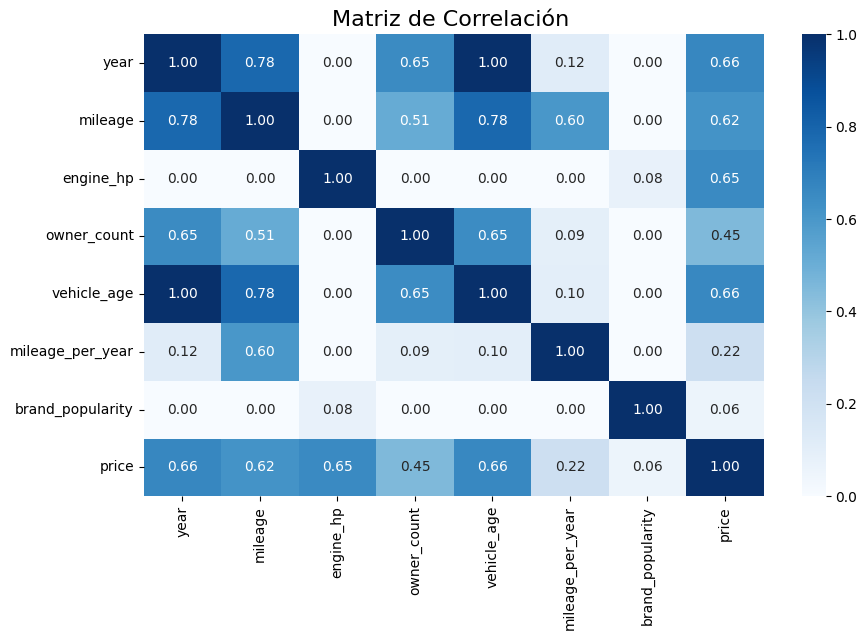

In [58]:
print('\nMatriz correlacion variables numericas\n---------------------\n')

# Matriz de correlación en valor absoluto
corr = base[base.describe().columns].corr().abs()

# Heatmap con un solo color (ej: Rojos)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="Blues", vmin=0, vmax=1, fmt=".2f")
plt.title("Matriz de Correlación ", fontsize=16)
plt.show()



# MODELOS

In [12]:

Y=base['price']
base=base.drop(columns=['vehicle_age','price','body_type','exterior_color','interior_color','mileage_per_year'])

In [13]:
# base.head()
# base

In [14]:
variabeles_categoricas=base.drop(columns=base.describe().columns.to_list())
variabeles_numericas=base.drop(columns=variabeles_categoricas)

In [16]:
df_dummies = pd.get_dummies(variabeles_categoricas, drop_first=False)
df_dummies = df_dummies.astype(int)

In [18]:
df=pd.concat([variabeles_numericas,df_dummies],axis=1)
X=df.copy()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [40]:
# Entrenamos un modelo de árbol de decisión para regresiones
clf = tree.DecisionTreeRegressor(max_depth=5, criterion="friedman_mse")
clf = clf.fit(X_train, y_train)



In [39]:
print('Modelo Arbol de decision\n--------------------\n')

Modelo Arbol de decision
--------------------



In [21]:
# Predicimos el costo
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)

In [22]:
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
r2_train = r2_score(y_train, preds_train)
r2_test = r2_score(y_test, preds_test)
print(f"RMSE Train:{rmse_train}")
print(f"RMSE Test:{rmse_test}")
print(f"R**2 Train: {r2_train:.4f}")
print(f"R**2 Test: {r2_test:.4f}")

RMSE Train:4470.6572075051345
RMSE Test:4477.05199224122
R**2 Train: 0.8926
R**2 Test: 0.8924


In [ ]:
print('Modelo Random Forest Regressor\n--------------------\n')

Modelo Random Forest Regressor


In [23]:
clf = ensemble.RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=1
)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
# Predicimos el costo
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)

In [25]:
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
r2_train = r2_score(y_train, preds_train)
r2_test = r2_score(y_test, preds_test)
print(f"RMSE Train:{rmse_train}")
print(f"RMSE Test:{rmse_test}")
print(f"R**2 Train: {r2_train:.4f}")
print(f"R**2 Test: {r2_test:.4f}")

RMSE Train:3586.110950389675
RMSE Test:3650.5923572065917
R**2 Train: 0.9309
R**2 Test: 0.9284


In [38]:
print('Modelo XGBRegressor\n--------------------\n')

Modelo XGBRegressor
--------------------



In [26]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train,y_train)
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5]
}
from sklearn.model_selection import RandomizedSearchCV

rand_search = RandomizedSearchCV(
    estimator=xg_reg,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=1
)
rand_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,1
,error_score,nan


In [27]:
# Predicimos el costo
preds_train = rand_search.predict(X_train)
preds_test = rand_search.predict(X_test) 


In [47]:
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
r2_train = r2_score(y_train, preds_train)
r2_test = r2_score(y_test, preds_test)
print(f"RMSE Train:{rmse_train}")
print(f"RMSE Test:{rmse_test}")
print(f"R**2 Train: {r2_train:.4f}")
print(f"R**2 Test: {r2_test:.4f}\n\n\n")

RMSE Train:1378.9391504108553
RMSE Test:1385.4310011074144
R**2 Train: 0.9898
R**2 Test: 0.9897





## Selección del modelo final

Se probaron tres modelos de regresión: Árbol de Decisión, Random Forest y XGBoost.  
El modelo seleccionado fue **XGBoost** porque obtuvo el mejor desempeño en las métricas de validación (menor RMSE y mayor R**2), mostrando mejor capacidad de generalización y menor sobreajuste respecto a los otros modelos. 

In [29]:


datos={ 'year':2018,
        'mileage':41000,
        'engine_hp':70,
        'owner_count':2,
        'make':'Kia',
        'model':'Forte',
        'transmission':'Automatic',
        'accident_history':'Major',
        'seller_type':'Private',
        'condition':'Good',
        'trim':'LX',
        'fuel_type':'Electric',
        'drivetrain':'AWD'       
}

columnas_entrenamiento=X_train.columns
X_new = pd.DataFrame([datos])
X_new['brand_popularity'] = base.loc[base['model'] == datos['model'], 'brand_popularity'].mean()
X_new_onehot = pd.get_dummies(X_new, columns=variabeles_categoricas.columns)
X_new_onehot = X_new_onehot.reindex(columns=columnas_entrenamiento,fill_value=0)
X_new_onehot = X_new_onehot.astype(int)


In [41]:
y_pred = rand_search.predict(X_new_onehot)
##print("Precio estimado:", y_pred[0])

- Vemos el peso de las variables en el modelo


variable_limpia
make            0.402463
engine          0.207852
year            0.155213
mileage         0.115628
accident        0.052416
condition       0.027028
brand           0.018842
seller          0.008382
owner           0.007223
model           0.004809
transmission    0.000042
trim            0.000037
drivetrain      0.000034
fuel            0.000029
Name: importance, dtype: float32


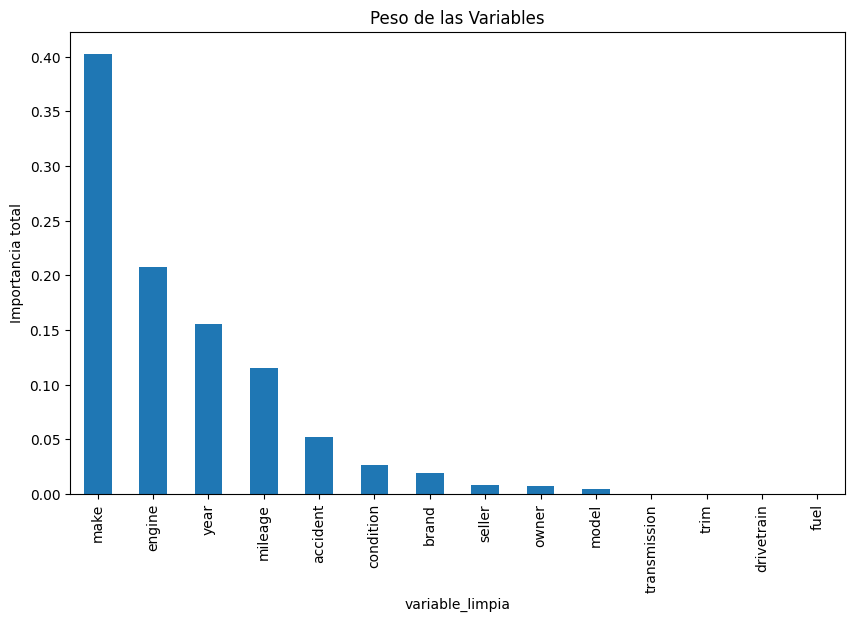

In [31]:
# feature importances individuales
importancia = rand_search.best_estimator_.feature_importances_
variables = X_train.columns
df_importancia = pd.DataFrame({'feature': variables, 'importance': importancia})
df_importancia['variable_limpia'] = df_importancia['feature'].apply(lambda x: x.split('_')[0])
importance_grouped = df_importancia.groupby('variable_limpia')['importance'].sum().sort_values(ascending=False)

# Mostrar
print(importance_grouped)

# Gráfico
plt.figure(figsize=(10,6))
importance_grouped.plot(kind='bar')
plt.ylabel('Importancia total')
plt.title('Peso de las Variables')
plt.show()


In [32]:
### ARCHIVOS AUXILIARES PARA ARMAR EL .PY 

variabeles_categoricas.head(1).to_csv("vars_cat.csv")
X_train.head(1).to_csv("X_train_cols.csv")
base1=base.copy()
base1['engine_hp']=base1['engine_hp'].astype('str')
base1.groupby(['make','model']).agg(brand_popularit=('brand_popularity','mean'),
                         #model=('model','unique'),
                         transmission=('transmission','unique'),
                         seller_type=('seller_type','unique'),
                         condition=('condition','unique'),
                         trim=('trim','unique'),
                         fuel_type=('fuel_type','unique'),
                         drivetrain=('drivetrain','unique'),
                         engine_hp=('engine_hp','unique')).to_csv('brand_marca.csv',sep=";")

joblib.dump(rand_search, "modelo_entrenado.pkl")

['modelo_entrenado.pkl']